# Objective (from the Work and Papers of Yibin Ng)
* 20191002: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using Xgboost
* 20191004 - Diff from StockPricePrediction_v6_xgboost.ipynb:
    * Instead of using mean and std from train set to do scaling/unscaling, use mean and std from the last N days to do scaling/unscaling
* 20191007 - Diff from StockPricePrediction_v6a_xgboost.ipynb:
    * Include a validation set to do hyperparameter tuning
* 20191018 - Diff from StockPricePrediction_v6b_xgboost.ipynb:
    * Instead of tuning N, we use a fixed N and observe the results
* 20191021 - Diff from StockPricePrediction_v6c_xgboost.ipynb:
    * Instead of using only features about price, introduce more features and observe the results

In [1]:
!nvidia-smi

Wed Aug  4 11:02:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   52C    P5    N/A /  N/A |    220MiB /  4096MiB |     23%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# import chart_studio.plotly as py
import plotly.offline as py
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from fastai import *
from fastai.tabular.all import *
# from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "C:/Users/Mister KwameNtow/Documents/GitHub/project/hedging/datasets"
filename = "/GHS-USD.csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = int(input("Number of days to predict on: "))               # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = int(input("Number of days to forecast on: "))                           # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*5            # Use 4 years of data as train set. Note there are about 252 trading days in a year
val_size = 252*2                 # Use 1.5 years(18mths) of data as validation set
N = 15                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 4                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.01            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1764


In [3]:
tic1 = time.time()

# Common functions

In [4]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [5]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def do_scaling(df, N):
    """
    Do scaling for the adj_close and lag cols
    """
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    for n in range(N,0,-1):
        df.loc[:, 'adj_close_scaled_lag_'+str(n)] = \
            (df['adj_close_lag_'+str(n)] - df['adj_close_mean']) / df['adj_close_std']
        
        # Remove adj_close_lag column which we don't need anymore
        df.drop(['adj_close_lag_'+str(n)], axis=1, inplace=True)

    return df

def pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val
        
        # Create the features dataframe
        X = X_test_ex_adj_close[n:n+1].copy()
        for n in range(N,0,-1):
            X.loc[:, "adj_close_scaled_lag_"+str(n)] = forecast_scaled[-n]
        
        # Do prediction
        est_scaled = model.predict(X)
        
        # Unscale the prediction
        forecast = np.concatenate([forecast, 
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])
        
        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])
           
    return forecast[-H:]

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          X_test_ex_adj_close,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_

def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        X_test_ex_adj_close = test[features_ex_adj_close]
        y_test = test['adj_close']
        prev_vals = train[-N:]['adj_close'].to_numpy()
        prev_mean_val = test.iloc[0]['adj_close_mean']
        prev_std_val = test.iloc[0]['adj_close_std']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        X_test_ex_adj_close,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    X_test_ex_adj_close = test[features_ex_adj_close]
    y_test = test['adj_close']
    prev_vals = train[-N:]['adj_close'].to_numpy()
    prev_mean_val = test.iloc[0]['adj_close_mean']
    prev_std_val = test.iloc[0]['adj_close_std']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      X_test_ex_adj_close,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

# Load data

In [6]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,range,close,adj_close,volume,status
0,2007-07-11,0.89961,0.90289,0.89840,0.00255,0.90216,0.90216,0.0,INCREASING
1,2007-07-12,0.90220,0.90986,0.89935,0.00614,0.90834,0.90834,0.0,INCREASING
2,2007-07-13,0.90831,0.91186,0.90801,0.00289,0.91120,0.91120,0.0,INCREASING
3,2007-07-16,0.91186,0.91239,0.90733,-0.00324,0.90862,0.90862,0.0,DECREASING
4,2007-07-17,0.90868,0.91120,0.90733,0.00107,0.90975,0.90975,0.0,INCREASING
5,2007-07-18,0.90972,0.91072,0.90699,-0.0019,0.90782,0.90782,0.0,DECREASING
6,2007-07-19,0.90775,0.90891,0.90602,0.00031,0.90806,0.90806,0.0,INCREASING
7,2007-07-20,0.90799,0.91365,0.90733,0.00272,0.91071,0.91071,0.0,INCREASING
8,2007-07-23,0.91051,0.91291,0.90985,0.00193,0.91244,0.91244,0.0,INCREASING
9,2007-07-24,0.91244,0.91258,0.90662,-0.00448,0.90796,0.90796,0.0,DECREASING


In [7]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [8]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'Trade Rate'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=filename)

# Feature Engineering

In [9]:
#create features
add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this
# df.drop('status', axis=1, inplace=True)
df.drop('range', axis=1, inplace=True)

df.head(50)

,date,adj_close,status,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2007-07-11,0.90216,INCREASING,2007,7,28,11,2,192,False,False,False,False,False,False
1,2007-07-12,0.90834,INCREASING,2007,7,28,12,3,193,False,False,False,False,False,False
2,2007-07-13,0.91120,INCREASING,2007,7,28,13,4,194,False,False,False,False,False,False
3,2007-07-16,0.90862,DECREASING,2007,7,29,16,0,197,False,False,False,False,False,False
4,2007-07-17,0.90975,INCREASING,2007,7,29,17,1,198,False,False,False,False,False,False
5,2007-07-18,0.90782,DECREASING,2007,7,29,18,2,199,False,False,False,False,False,False
6,2007-07-19,0.90806,INCREASING,2007,7,29,19,3,200,False,False,False,False,False,False
7,2007-07-20,0.91071,INCREASING,2007,7,29,20,4,201,False,False,False,False,False,False
8,2007-07-23,0.91244,INCREASING,2007,7,30,23,0,204,False,False,False,False,False,False
9,2007-07-24,0.90796,DECREASING,2007,7,30,24,1,205,False,False,False,False,False,False


In [10]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [11]:
# Convert year to categorical feature, based on alphabetical order and status as well
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
df.loc[:, 'status']=LabelEncoder().fit_transform(df['status'])
df[15:25]

,date,adj_close,status,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
15,2007-08-01,0.91148,1,0,8,31,1,2,213,False,True,False,False,False,False
16,2007-08-02,0.91568,2,0,8,31,2,3,214,False,False,False,False,False,False
17,2007-08-03,0.90953,1,0,8,31,3,4,215,False,False,False,False,False,False
18,2007-08-06,0.91204,2,0,8,32,6,0,218,False,False,False,False,False,False
19,2007-08-07,0.91241,2,0,8,32,7,1,219,False,False,False,False,False,False
20,2007-08-08,0.90823,1,0,8,32,8,2,220,False,False,False,False,False,False
21,2007-08-09,0.92383,2,0,8,32,9,3,221,False,False,False,False,False,False
22,2007-08-10,0.91773,1,0,8,32,10,4,222,False,False,False,False,False,False
23,2007-08-13,0.91642,1,0,8,33,13,0,225,False,False,False,False,False,False
24,2007-08-14,0.91395,1,0,8,33,14,1,226,False,False,False,False,False,False


# EDA

In [12]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                 0
adj_close           11
status               0
year                 0
month                0
week                 0
day                  0
dayofweek            0
dayofyear            0
is_month_end         0
is_month_start       0
is_quarter_end       0
is_quarter_start     0
is_year_end          0
is_year_start        0
dtype: int64

In [13]:
df=df.fillna(df['adj_close'].mean())
df

,date,adj_close,status,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2007-07-11,0.90216,2,0,7,28,11,2,192,False,False,False,False,False,False
1,2007-07-12,0.90834,2,0,7,28,12,3,193,False,False,False,False,False,False
2,2007-07-13,0.91120,2,0,7,28,13,4,194,False,False,False,False,False,False
3,2007-07-16,0.90862,1,0,7,29,16,0,197,False,False,False,False,False,False
4,2007-07-17,0.90975,2,0,7,29,17,1,198,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-03-13,5.49000,1,13,3,11,13,4,73,False,False,False,False,False,False
3308,2020-03-16,5.49000,1,13,3,12,16,0,76,False,False,False,False,False,False
3309,2020-03-17,5.53000,1,13,3,12,17,1,77,False,False,False,False,False,False
3310,2020-03-18,5.55813,1,13,3,12,18,2,78,False,False,False,False,False,False


In [14]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

date                0
adj_close           0
status              0
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

In [15]:
# Compute the average price for each month
avg_price_mth = df.groupby("month").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_mth['month'],
            y = avg_price_mth['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'month'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='ForexPricePrediction_v6d_avg_price_mth')

In [16]:
# Compute the average price for each day of month
avg_price_day = df.groupby("day").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_day['day'],
            y = avg_price_day['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of month'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='ForexPricePrediction_v6d_avg_price_dayofmonth')

In [17]:
# Compute the average price for each day of week
avg_price_dayofweek = df.groupby("dayofweek").agg({'adj_close': 'mean'}).reset_index()

# Plot 
data = [go.Scatter(
            x = avg_price_dayofweek['dayofweek'],
            y = avg_price_dayofweek['adj_close'],
            mode = 'markers',
            marker=dict(
                color='LightSkyBlue',
                size=15,
                line=dict(
                color='MediumPurple',
                width=2
                ))
        )]

layout = dict(xaxis = dict(title = 'day of week'),
              yaxis = dict(title = 'average adjusted closing price (USD)'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='ForexPricePrediction_v6d_avg_price_dayofweek')

In [18]:
# Create lags 
df_lags = add_lags(df, N, ['adj_close'])
df_lags

,date,adj_close,status,year,month,week,day,dayofweek,dayofyear,is_month_end,...,adj_close_lag_6,adj_close_lag_7,adj_close_lag_8,adj_close_lag_9,adj_close_lag_10,adj_close_lag_11,adj_close_lag_12,adj_close_lag_13,adj_close_lag_14,adj_close_lag_15
0,2007-07-11,0.90216,2,0,7,28,11,2,192,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-07-12,0.90834,2,0,7,28,12,3,193,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-07-13,0.91120,2,0,7,28,13,4,194,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-07-16,0.90862,1,0,7,29,16,0,197,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-07-17,0.90975,2,0,7,29,17,1,198,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-03-13,5.49000,1,13,3,11,13,4,73,False,...,5.41,5.39,5.36,5.35,5.36,5.32,5.32,5.31,5.30,5.34
3308,2020-03-16,5.49000,1,13,3,12,16,0,76,False,...,5.42,5.41,5.39,5.36,5.35,5.36,5.32,5.32,5.31,5.30
3309,2020-03-17,5.53000,1,13,3,12,17,1,77,False,...,5.41,5.42,5.41,5.39,5.36,5.35,5.36,5.32,5.32,5.31
3310,2020-03-18,5.55813,1,13,3,12,18,2,78,False,...,5.45,5.41,5.42,5.41,5.39,5.36,5.35,5.36,5.32,5.32


In [19]:
# Compute correlation
features = [
        'adj_close', 'status',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["adj_close"].sort_values(ascending=False)

adj_close           1.000000
year                0.472687
adj_close_lag_1     0.234312
adj_close_lag_2     0.234194
adj_close_lag_4     0.233925
adj_close_lag_3     0.233925
adj_close_lag_5     0.233712
adj_close_lag_6     0.233432
adj_close_lag_7     0.233222
adj_close_lag_8     0.232926
adj_close_lag_9     0.232772
adj_close_lag_10    0.232665
adj_close_lag_11    0.232424
adj_close_lag_12    0.232300
adj_close_lag_13    0.231971
adj_close_lag_14    0.231954
adj_close_lag_15    0.231825
status              0.027282
day                 0.006099
is_year_start       0.001971
dayofweek          -0.000559
is_month_start     -0.001487
is_year_end        -0.003642
is_quarter_start   -0.004191
is_month_end       -0.004505
week               -0.006528
dayofyear          -0.006944
month              -0.007084
is_quarter_end     -0.008656
Name: adj_close, dtype: float64

In [20]:
# Plot correlation for lag features only
features = ['adj_close']
for n in range(1,N+1,1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='ForexPricePrediction_v6d_corr_matrix_lags')

In [21]:
# Plot correlation for date features only
features = [
        'adj_close', 'status',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
        
corr_matrix = df_lags[features].corr()

z_list = []
for feat in features:
    z_list.append(corr_matrix.loc[:, feat][features])

fig = go.Figure(data=go.Heatmap(
                   z=z_list,
                   x=features,
                   y=features))
py.iplot(fig, filename='ForexPricePrediction_v6d_corr_matrix_dates')

# Split into train, validation, test

In [22]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 2700, date 2017-11-15 00:00:00, with forecast horizon H = 30


In [23]:
train = df[(pred_day-train_val_size):(pred_day-val_size)].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (1260, 15)
val.shape = (504, 15)
train_val.shape = (1764, 15)
test.shape = (30, 15)


In [24]:
df.head(5)

,date,adj_close,status,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,2007-07-11,0.90216,2,0,7,28,11,2,192,False,False,False,False,False,False
1,2007-07-12,0.90834,2,0,7,28,12,3,193,False,False,False,False,False,False
2,2007-07-13,0.91120,2,0,7,28,13,4,194,False,False,False,False,False,False
3,2007-07-16,0.90862,1,0,7,29,16,0,197,False,False,False,False,False,False
4,2007-07-17,0.90975,2,0,7,29,17,1,198,False,False,False,False,False,False


# Predict for a specific H (forecast horizon) and a specific date

In [25]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

RMSE = 0.725
MAPE = 15.291%
MAE = 0.599%


In [26]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2007-07-11', '2018-11-12'])
fig.update_yaxes(range=[127, 157])
py.iplot(fig, filename='ForexPricePrediction_v6d_xgboost_val')

In [27]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 0.299
MAPE = 3.900%
MAE = 0.148


In [28]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [29]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('year', 0.0),
 ('month', 0.0),
 ('dayofyear', 0.0),
 ('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('adj_close_scaled_lag_11', 0.0),
 ('adj_close_scaled_lag_8', 0.0),
 ('adj_close_scaled_lag_5', 0.0),
 ('day', 8.228131e-08),
 ('dayofweek', 1.6836047e-07),
 ('week', 1.9985364e-07),
 ('adj_close_scaled_lag_4', 2.244849e-07),
 ('adj_close_scaled_lag_12', 2.3457618e-07),
 ('adj_close_scaled_lag_6', 2.6418107e-07),
 ('adj_close_scaled_lag_7', 2.976064e-07),
 ('adj_close_scaled_lag_2', 9.367685e-07),
 ('adj_close_scaled_lag_1', 4.3100817e-06),
 ('adj_close_scaled_lag_9', 6.102307e-06),
 ('adj_close_scaled_lag_3', 6.769721e-06),
 ('adj_close_scaled_lag_13', 1.5729489e-05),
 ('adj_close_scaled_lag_15', 5.5927943e-05),
 ('adj_close_scaled_lag_14', 0.00011103315),
 ('adj_close_scaled_lag_10', 0.99979776)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [30]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [31]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-31-a8f23e722eeb>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 84.24


,n_estimators,max_depth,rmse,mape,mae
0,1,2,0.139229,2.643147,0.090351
1,1,3,0.138167,2.617168,0.089310
2,1,4,0.138092,2.615447,0.089240
3,1,5,0.138114,2.615859,0.089255
4,1,6,0.138059,2.614232,0.089193
...,...,...,...,...,...
235,59,5,0.270721,5.237311,0.202326
236,59,6,0.153591,2.933885,0.101344
237,59,7,0.161397,3.133599,0.109290
238,59,8,0.165107,3.116394,0.108786


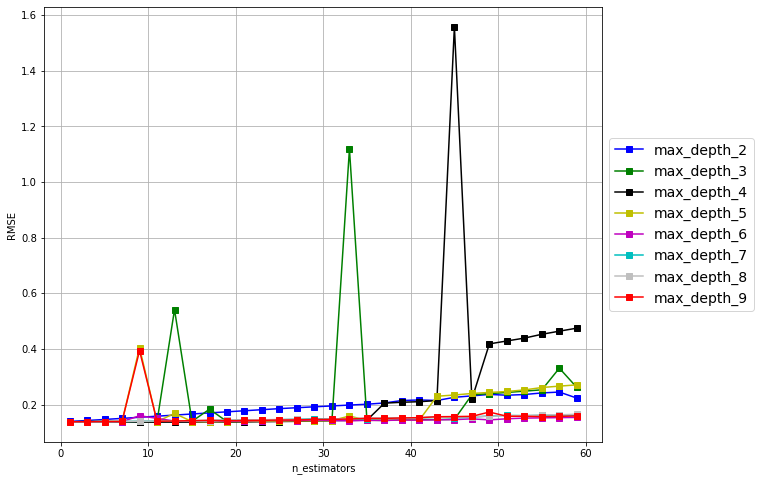

In [32]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [33]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.137
optimum params = 


(13, 4)

In [34]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 2.590%
optimum params = 


(11, 4)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [35]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-35-6b3e473182cf>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 21.79


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,1.381984e-01,2.616436e+00,8.927368e-02
1,0.0001,6,1.381041e-01,2.614212e+00,8.918501e-02
2,0.0001,7,1.382480e-01,2.617959e+00,8.932571e-02
3,0.0001,8,1.382455e-01,2.617174e+00,8.929790e-02
4,0.0001,9,1.382083e-01,2.616788e+00,8.928876e-02
...,...,...,...,...,...
123,0.3000,16,2.774330e+16,1.686309e+17,6.429148e+15
124,0.3000,17,4.962128e+06,3.878888e+07,1.505443e+06
125,0.3000,18,2.450989e+18,1.432371e+19,5.461930e+17
126,0.3000,19,7.374717e+09,4.252845e+10,1.690363e+09


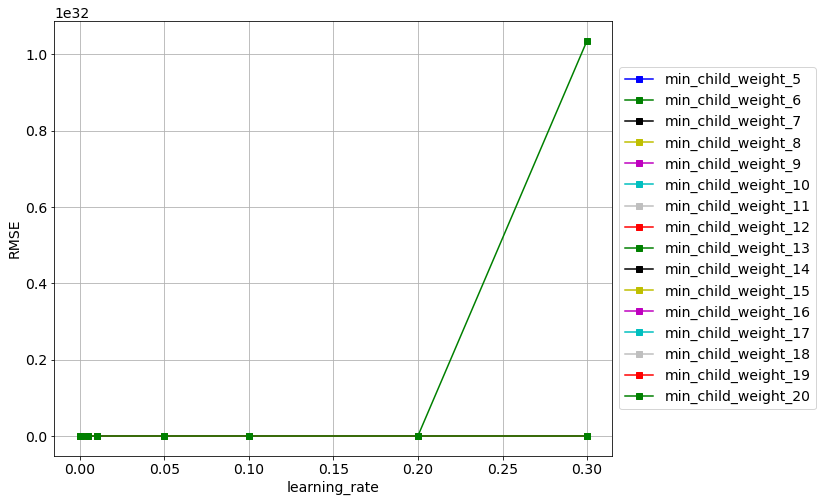

In [36]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [37]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.138
optimum params = 


(0.0001, 20)

In [38]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 2.613%
optimum params = 


(0.0001, 20)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [39]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-39-d301315f9d33>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 18.01


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,0.137983,2.611016,0.089059
1,0.1,0.1,0.137983,2.611016,0.089059
2,0.1,0.2,0.137983,2.611016,0.089059
3,0.1,0.3,0.137983,2.611016,0.089059
4,0.1,0.4,0.137983,2.611016,0.089059
...,...,...,...,...,...
105,1.0,0.6,0.138052,2.613497,0.089156
106,1.0,0.7,0.138052,2.613497,0.089156
107,1.0,0.8,0.138052,2.613497,0.089156
108,1.0,0.9,0.138052,2.613497,0.089156


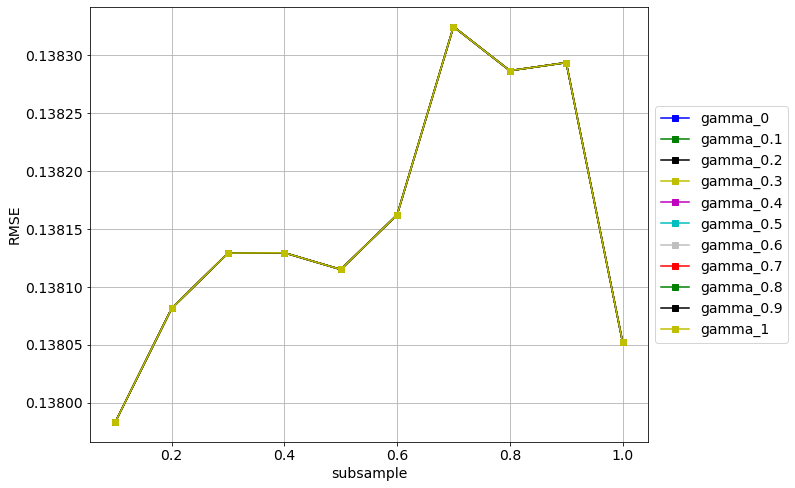

In [40]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [41]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.138
optimum params = 


(0.1, 0.0)

In [42]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 2.611%
optimum params = 


(0.1, 1.0)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [43]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   

<ipython-input-43-7f9906fc6bdb>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 4.94


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,0.138034,2.612655,0.089118
1,0.5,0.6,0.137996,2.611940,0.089093
2,0.5,0.7,0.137997,2.611808,0.089086
3,0.5,0.8,0.138009,2.612286,0.089105
4,0.5,0.9,0.138014,2.611852,0.089092
5,0.5,1.0,0.138001,2.611546,0.089080
6,0.6,0.5,0.138036,2.612982,0.089132
7,0.6,0.6,0.138036,2.612947,0.089131
8,0.6,0.7,0.138106,2.614887,0.089206
9,0.6,0.8,0.138005,2.611544,0.089080


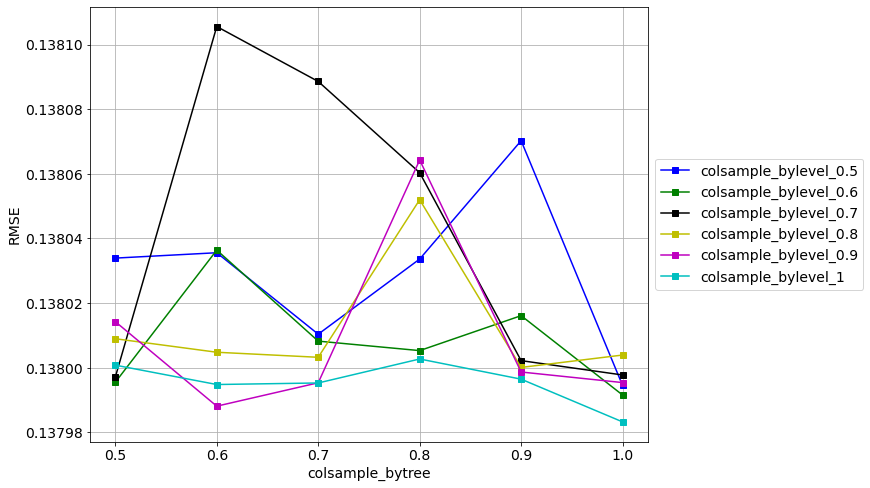

In [44]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [45]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.138
optimum params = 


(1.0, 1.0)

In [46]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 2.611%
optimum params = 


(1.0, 1.0)

## Final model

In [47]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 0.138
MAPE = 2.611%
MAE = 0.089


In [48]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2008-10-16', '2010-11-12'])
fig.update_yaxes(range=[127, 157])
py.iplot(fig, filename='ForexPricePrediction_v6d_xgboost_val_aft_tune')

In [49]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 0.299
MAPE = 3.980%
MAE = 0.152


In [50]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='actual',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [51]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('month', 0.0),
 ('week', 0.0),
 ('dayofweek', 0.0),
 ('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('adj_close_scaled_lag_6', 0.0),
 ('adj_close_scaled_lag_11', 7.541116e-07),
 ('year', 9.153935e-07),
 ('dayofyear', 1.1153136e-06),
 ('adj_close_scaled_lag_9', 1.4504118e-06),
 ('adj_close_scaled_lag_10', 1.984475e-06),
 ('adj_close_scaled_lag_4', 3.6644362e-06),
 ('adj_close_scaled_lag_7', 4.680526e-06),
 ('adj_close_scaled_lag_3', 5.0159165e-06),
 ('adj_close_scaled_lag_2', 5.933899e-06),
 ('adj_close_scaled_lag_1', 7.916232e-06),
 ('day', 8.359256e-06),
 ('adj_close_scaled_lag_15', 1.1280774e-05),
 ('adj_close_scaled_lag_8', 2.2709914e-05),
 ('adj_close_scaled_lag_13', 2.478422e-05),
 ('adj_close_scaled_lag_12', 3.7315353e-05),
 ('adj_close_scaled_lag_14', 0.00013114997),
 ('adj_close_scaled_lag_5', 0.99973094)]

In [52]:
# Plot the importance scores as a bar chart
fig = go.Figure(go.Bar(
            x=[item[1] for item in imp[-10:]],
            y=[item[0] for item in imp[-10:]],
            orientation='h'))
py.iplot(fig, filename='ForexPricePrediction_v6d_xgboost_imp_scores')

## Tuned params

In [53]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,13.000
1,max_depth,4.000,4.000
2,learning_rate,0.010,0.000
3,min_child_weight,1.000,20.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.000
8,val_rmse,0.725,0.138
9,val_mape,15.291,2.611


In [54]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./datasets/withHeaders/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [55]:
pickle.load(open("./datasets/withHeaders/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "rb"))

,param,before_tuning,after_tuning
0,n_estimators,100.000,13.000
1,max_depth,4.000,4.000
2,learning_rate,0.010,0.000
3,min_child_weight,1.000,20.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.000
8,val_rmse,0.725,0.138
9,val_mape,15.291,2.611


In [56]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 129.97


# Findings

In [57]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 2700, date 2017-11-15, with forecast horizon H = 30


In [58]:
rmse_bef_tuning, rmse_aft_tuning

(0.7252351202899103, 0.13798323618154504)

In [59]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(0.29923935253537326, 0.2994823849715015)

In [60]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./datasets/withHeaders/v6d_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./datasets/withHeaders/v6d_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./datasets/withHeaders/v6d_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./datasets/withHeaders/v6d_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./datasets/withHeaders/v6d_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./datasets/withHeaders/v6d_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./datasets/withHeaders/v6d_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./datasets/withHeaders/v6d_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(est, open("./datasets/withHeaders/v6d_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [67]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-06-28',
            #  '2017-03-06',
            #  '2017-05-04',
            #  '2017-07-05',
            #  '2017-09-01',
             '2017-11-15',
            #  '2018-01-03',
            #  '2018-03-06',
            #  '2018-05-04',
            #  '2018-0-05',
            #  '2018-09-04',
            #  '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./datasets/withHeaders/v6d_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

,date,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning,test_mape_bef_tuning,test_mape_aft_tuning,test_mae_bef_tuning,test_mae_aft_tuning
0,2017-06-28,0.618571,0.144831,0.297050,0.297324,2.627134,2.675962,0.085018,0.087119
1,2017-11-15,0.725235,0.137983,0.299239,0.299482,3.900044,3.979510,0.148035,0.151740


In [68]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./datasets/withHeaders/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./datasets/withHeaders/v6d_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

,date,RMSE,MAPE(%),MAE,n_estimators,max_depth,learning_rate,min_child_weight
0,2017-06-28,0.297324,2.675962,0.087119,7.0,4.0,0.0,15.0
1,2017-11-15,0.299482,3.979510,0.151740,13.0,4.0,0.0,20.0


In [63]:
results.mean()

val_rmse_bef_tuning     0.618571
val_rmse_aft_tuning     0.144831
test_rmse_bef_tuning    0.297050
test_rmse_aft_tuning    0.297324
test_mape_bef_tuning    2.627134
test_mape_aft_tuning    2.675962
test_mae_bef_tuning     0.085018
test_mae_aft_tuning     0.087119
dtype: float64

In [64]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2016-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
py.iplot(fig, filename='ForexPricePrediction_v6d_xgboost_predictions')

In [65]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.iplot(fig, filename='ForexPricePrediction_v6d_xgboost_actuals_vs_predictions')

In [66]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features'],
                            'RMSE': [2.53, 2.32, 2.42],
                            'MAPE(%)': [1.69, 1.53, 1.61],
                            'MAE': [2.26, 2.05, 2.15]})
all_results

,Method,RMSE,MAPE(%),MAE
0,Last value,2.53,1.69,2.26
1,XGBoost w/o date features,2.32,1.53,2.05
2,XGBoost w date features,2.42,1.61,2.15
